In [1]:
from __future__ import print_function
import time,sys,statistics,csv,math
import numpy as np

## The possible attributes in the data with the prediction at index 0. Smaller names for brevity.
attributes = ["rich","age","wc","fnlwgt","edu","edun","mar","occ","rel","race","sex","capg","canpl","hpw","nc"]

## Get the encoding of the csv file by replacing each categorical attribute value by its index.
wc_l = "Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked".split(", ")
edu_l = "Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool".split(", ")
mar_l = "Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse".split(", ")
occ_l = "Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces".split(", ")
rel_l = "Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried".split(", ")
race_l = "White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black".split(", ")
sex_l = "Female, Male".split(", ")
nc_l = "United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands".split(", ")
encode = {
    "rich"   : {"0":0,"1":1},
    "wc"     : {wc_l[i]:i for i in range(len(wc_l))},
    "edu"    : {edu_l[i]:i for i in range(len(edu_l))},
    "mar"    : {mar_l[i]:i for i in range(len(mar_l))},
    "occ"    : {occ_l[i]:i for i in range(len(occ_l))},
    "rel"    : {rel_l[i]:i for i in range(len(rel_l))},
    "race"   : {race_l[i]:i for i in range(len(race_l))},
    "sex"    : {sex_l[i]:i for i in range(len(sex_l))},
    "nc"     : {nc_l[i]:i for i in range(len(nc_l))},
    }

def medians(file):
    """
    Given a csv file, find the medians of the categorical attributes for the whole data.
    params(1):
        file : string : the name of the file
    outputs(6):
        median values for the categorical columns
    """
    fin = open(file,"r")
    reader = csv.reader(fin)
    age, fnlwgt, edun, capg, capl, hpw = ([] for i in range(6))
    total = 0
    for row in reader:
        total+=1
        if(total==1):
            continue
        l = [x.lstrip().rstrip() for x in row]
        age.append(int(l[0]));
        fnlwgt.append(int(l[2]));
        edun.append(int(l[4]));
        capg.append(int(l[10]));
        capl.append(int(l[11]));
        hpw.append(int(l[12]));
    fin.close()
    return(statistics.median(age),statistics.median(fnlwgt),statistics.median(edun),statistics.median(capg),statistics.median(capl),statistics.median(hpw))

def preprocess(file,median):
    """
    Given a file, read its data by encoding categorical attributes and binarising continuos attributes based on median.
    params(1):
        file : string : the name of the file
    outputs(6):
        2D numpy array with the data
    """
    # Calculate the medians
    agem,fnlwgtm,edunm,capgm,caplm,hpwm = medians(file)
    fin = open(file,"r")
    reader = csv.reader(fin)
    data = []
    total = 0
    for row in reader:
        total+=1
        # Skip line 0 in the file
        if(total==1):
            continue
        l = [x.lstrip().rstrip() for x in row]
        t = [0 for i in range(15)]

        # Encode the categorical attributes
        t[0] = encode["rich"][l[-1]]; t[2] = encode["wc"][l[1]]; t[4] = encode["edu"][l[3]]
        t[6] = encode["mar"][l[5]]; t[7] = encode["occ"][l[6]]; t[8] = encode["rel"][l[7]]
        t[9] = encode["race"][l[8]]; t[10] = encode["sex"][l[9]]; t[14] = encode["nc"][l[13]]

        # Binarize the numerical attributes based on median.
        # Modify this section to read the file in part c where you split the continuos attributes baed on dynamic median values.
        if median:
            t[1] = float(l[0])>=agem; t[3] = float(l[2])>=fnlwgtm; t[5] = float(l[4])>=edunm;
            t[11] = float(l[10])>=capgm; t[12] = float(l[11])>=caplm; t[13] = float(l[12])>=hpwm;
        else:
            t[1] = float(l[0]); t[3] = float(l[2]); t[5] = float(l[4]);
            t[11] = float(l[10]); t[12] = float(l[11]); t[13] = float(l[12]);
        # Convert some of the booleans to ints
        data.append([int(x) for x in t])

    return np.array(data,dtype=np.int64)

In [2]:
## Read the data
train_data = preprocess("../dataset/train.csv",1)
valid_data = preprocess("../dataset/valid.csv",1)
test_data = preprocess("../dataset/test.csv",1)
train_data_raw = preprocess("../dataset/train.csv",0)
valid_data_raw = preprocess("../dataset/valid.csv",0)
test_data_raw = preprocess("../dataset/test.csv",0)

print("The sizes are ","Train:",len(train_data),", Validation:",len(valid_data),", Test:",len(test_data))

The sizes are  Train: 27000 , Validation: 3000 , Test: 7000


In [3]:
cont_attribute = [1,3,5,11,12,13]

In [4]:
class Tree:
    def __init__(self):
        attr = None
        label =None
        child_list = None
        index_in_list = None
        thresh = None
        is_leaf =None

In [5]:
def i_gain(pos_val,neg_val):
    total = pos_val + neg_val
    i_gain_val =  -1 * ((1.0 * pos_val)/total) * math.log((1.0 * pos_val)/total) - ((1.0 * neg_val)/total)*math.log((1.0*neg_val)/total)
    return i_gain_val

In [6]:
def median_data(pos_list,neg_list,attribute):
    attr_data = []
    for i in range(len(pos_list)):
        ind = pos_list[i]
        attr_value = train_data_raw[ind][attribute]
        attr_data.append(attr_value)
    for i in range(len(neg_list)):
        ind = neg_list[i]
        attr_value = train_data_raw[ind][attribute]
        attr_data.append(attr_value)
    median_value = statistics.median(attr_data)
    return median_value
    

In [7]:
def information_gain(pos_list,neg_list,attribute,raw):
    attr_map = {}
    total_examples = len(pos_list) + len(neg_list)
    if attribute in cont_attribute:
        median_value = median_data(pos_list,neg_list,attribute)
    for i in range(len(pos_list)):
        ind = pos_list[i]
        if (raw)  and (attribute in cont_attribute):
            attr_value = train_data_raw[ind][attribute] >= median_value
        else:
            attr_value = train_data[ind][attribute]
        if attr_value in attr_map:
            attr_map[attr_value][0] +=1
        else:
            attr_map[attr_value] = [1,0]
    for i in range(len(neg_list)):
        ind = neg_list[i]
        if (raw)  and (attribute in cont_attribute):
            attr_value = train_data_raw[ind][attribute] >= median_value
        else:
            attr_value = train_data[ind][attribute]
        if attr_value in attr_map:
            attr_map[attr_value][1] +=1
        else:
            attr_map[attr_value] = [0,1]
    i_gain_map = {}
    for key in attr_map.keys():
        pos_val = attr_map[key][0]
        neg_val = attr_map[key][1]
        if pos_val==0 or neg_val==0:
            i_gain_map[key] = 0
        else:
            i_gain_map[key] = i_gain(pos_val,neg_val)
    final_i_gain = 0.0
    for key in attr_map.keys():
        val_total = attr_map[key][0] + attr_map[key][1]
        final_i_gain += ((val_total/(1.0 * total_examples)) * i_gain_map[key])
    return final_i_gain

In [8]:
def best_attr(pos_list,neg_list,raw):
    minn = float("inf")
    ind = -1
    for i in range(14):
        inf_i = information_gain(pos_list,neg_list,i+1,raw)
#         print (i,inf_i)
        if inf_i < minn:
            ind = i+1
            minn = inf_i
    return ind

In [9]:
def make_tree(pos_list,neg_list,raw):
    global global_node_list
    if len(pos_list)==0:
        leaf_node = Tree()
        leaf_node.label = 0
        leaf_node.is_leaf = 1
        return leaf_node
    if len(neg_list)==0:
        leaf_node = Tree()
        leaf_node.label = 1
        leaf_node.is_leaf = 1
        return leaf_node
    pos_ex = len(pos_list)
    neg_ex = len(neg_list)
    curr_i_gain = i_gain(pos_ex,neg_ex)
    best_attribute = best_attr(pos_list,neg_list,raw)
    new_best_gain = information_gain(pos_list,neg_list,best_attribute,raw)
    new_node = Tree()
    if pos_ex > neg_ex :
        new_node.label = 1
    else:
        new_node.label = 0
    if curr_i_gain == new_best_gain:
        new_node.is_leaf = 1
        return new_node
    if raw:
        new_node.index_in_list = len(global_node_list_raw)
        global_node_list_raw.append(new_node)
    else:
        new_node.index_in_list = len(global_node_list)
        global_node_list.append(new_node)
    attr_map = {}
    new_node.attr = best_attribute
    if raw and (best_attribute in cont_attribute):
        median_value = median_data(pos_list,neg_list,best_attribute)
        new_node.thresh = median_value
    new_node.child_list = {}
    new_node.is_leaf=0
    for i in range(len(pos_list)):
        ind = pos_list[i]
        if (raw)  and (best_attribute in cont_attribute):
            attr_value = train_data_raw[ind][best_attribute] >= median_value
        else:
            attr_value = train_data[ind][best_attribute]
        if attr_value in attr_map:
            attr_map[attr_value][0].append(ind)
        else:
            attr_map[attr_value] = [[ind],[]]
    for i in range(len(neg_list)):
        ind = neg_list[i]
        if (raw)  and (best_attribute in cont_attribute):
            attr_value = train_data_raw[ind][best_attribute] >= median_value
        else:
            attr_value = train_data[ind][best_attribute]
        if attr_value in attr_map:
            attr_map[attr_value][1].append(ind)
        else:
            attr_map[attr_value] = [[],[ind]]
    print (best_attribute)
    for key in attr_map.keys():
        print (key,len(attr_map[key][0]),len(attr_map[key][1]))
    print ()
    for key in attr_map.keys():
        new_node.child_list[key] = (make_tree(attr_map[key][0],attr_map[key][1],raw))
    return new_node
    

In [10]:
base_pos = []
base_neg = []
global_node_list = []
global_node_list_raw = []
for i in range(len(train_data)):
    if train_data[i][0] == 1:
        base_pos.append(i)
    else:
        base_neg.append(i)
tree_root = make_tree(base_pos,base_neg,0)
tree_root_raw = make_tree(base_pos,base_neg,1)

8
0 628 629
1 57 3954
2 5071 6063
3 733 6202
4 28 769
5 184 2682

4
0 166 69
1 117 130
2 2 18
3 149 264
4 19 2
5 31 30
6 41 24
7 3 15
8 1 15
9 2 11
10 79 16
11 0 2
12 1 22
13 15 2
14 2 7
15 0 2

7
0 10 0
1 2 1
2 4 7
3 13 6
4 44 14
5 75 24
6 1 0
7 0 2
8 16 14
12 1 1

13
0 2 0
1 0 1

9
0 1 6
1 3 1

3
0 0 5
1 1 1

3
0 3 0
1 0 1

14
0 13 4
10 0 1
3 0 1

2
0 11 3
1 1 1
2 1 0

1
0 8 1
1 3 2

3
0 5 1
1 3 0

13
0 1 0
1 4 1

3
0 2 1
1 1 1

13
0 1 0
1 1 1

13
0 0 1
1 1 0

1
0 0 1
1 1 0

14
0 43 11
10 0 1
2 1 0
27 0 1
5 0 1

2
0 30 6
1 4 2
2 2 0
3 2 2
4 1 0
5 4 1

13
0 6 0
1 24 6

9
0 22 6
4 2 0

6
0 21 6
6 1 0

10
0 20 6
1 1 0

3
0 8 3
1 12 3

1
0 8 2
1 0 1

1
0 6 2
1 6 1

3
0 2 2
1 2 0

1
0 0 1
1 2 1

3
0 1 1
1 1 0

9
0 0 1
2 1 0

1
0 2 1
1 2 0

13
0 1 0
1 1 1

14
0 69 23
5 1 0
12 1 1
13 1 0
15 2 0
27 1 0

2
0 32 11
1 4 1
2 0 1
4 28 9
5 5 1

3
0 20 4
1 12 7

13
0 8 4
1 12 0

1
0 3 3
1 5 1

6
0 11 7
6 1 0

13
0 6 2
1 5 5

1
0 2 1
1 4 1

1
0 2 0
1 2 1

13
0 1 1
1 1 0

3
0 11 5
1 17 4

1
0 1 0
1 1

4
0 1428 633
1 912 1194
2 38 227
3 1162 2471
4 271 46
5 161 166
6 217 294
7 14 155
8 26 242
9 22 61
10 577 164
11 5 45
12 48 217
13 182 33
14 8 105
15 0 10

7
0 52 22
1 69 55
2 11 21
3 270 111
4 530 137
5 342 158
6 4 12
7 15 16
8 63 45
9 18 26
10 13 16
12 41 14

2
0 46 18
1 1 0
2 0 1
3 2 1
4 2 0
5 1 2

1
0 13 10
1 33 8

14
0 12 9
2 0 1
7 1 0

9
0 11 9
1 1 0

13
0 1 2
1 10 7

3
0 0 1
1 1 1

3
0 8 4
1 2 3

13
0 4 2
1 29 6

3
0 1 2
1 3 0

9
0 28 6
1 1 0

3
0 16 3
1 12 3

13
0 0 1
1 2 0

13
0 0 2
1 1 0

14
0 61 50
1 1 0
2 1 0
4 0 1
5 1 0
8 1 0
10 1 1
15 2 2
19 1 0
20 0 1

2
0 46 29
1 8 12
2 4 3
3 1 1
4 1 5
5 1 0

9
0 45 28
1 0 1
4 1 0

3
0 23 19
1 22 9

13
0 0 2
1 23 17

1
0 8 7
1 15 10

1
0 5 4
1 17 5

13
0 1 0
1 16 5

1
0 1 5
1 7 7

3
0 0 2
1 1 3

3
0 5 6
1 2 1

13
0 1 2
1 4 4

3
0 2 3
1 2 0

13
0 0 1
1 2 2

1
0 1 0
1 0 1

3
0 1 1
1 0 4

1
0 1 0
1 0 1

1
0 1 0
1 1 2

2
0 1 1
4 0 1

13
0 0 1
1 1 0

14
0 9 13
35 0 1
36 0 1
10 0 1
11 0 1
12 0 1
13 1 0
15 1 0
19 0 2
20 0 1

2
0 8 11
1 0 1
4 

0 0 1
1 2 2

1
0 1 4
1 0 4

14
0 1 3
24 0 1

1
0 0 1
1 3 1

3
0 1 1
1 2 0

1
0 1 2
1 2 0

9
0 0 1
4 1 1

9
0 32 21
3 1 0
4 0 2

3
0 9 10
1 23 11

1
0 4 5
1 5 5

1
0 10 7
1 13 4

13
0 1 0
1 12 4

1
0 0 7
1 6 6

13
0 0 1
1 6 5

3
0 3 3
1 3 2

7
0 0 1
1 12 65
2 2 20
3 3 12
4 4 13
5 0 2
6 5 17
7 2 36
8 2 6
9 2 14
10 5 40
12 1 1

2
0 10 55
1 0 8
2 1 0
4 1 1
5 0 1

1
0 3 32
1 7 23

14
0 3 30
20 0 2

3
0 1 15
1 2 15

13
0 0 1
1 2 14

3
0 5 11
1 2 12

9
0 5 10
4 0 1

13
0 0 1
1 5 9

14
0 2 10
12 0 1
31 0 1

13
0 0 1
1 2 9

1
0 0 1
1 1 0

13
0 0 5
1 2 15

2
0 2 12
1 0 1
4 0 2

9
0 1 10
4 1 2

3
0 1 4
1 0 6

1
0 0 1
1 1 3

3
0 0 2
1 1 0

1
0 0 5
1 3 7

2
0 3 6
1 0 1

3
0 3 5
1 0 1

13
0 1 1
1 2 4

2
0 2 5
1 1 6
2 1 1
4 0 1

3
0 1 1
1 1 4

1
0 1 0
1 0 1

1
0 0 3
1 1 1

13
0 0 3
1 1 3

1
0 0 2
1 1 1

3
0 1 0
1 0 1

3
0 1 0
1 0 1

1
0 1 11
1 4 6

14
0 1 7
19 0 1
20 0 2
29 0 1

3
0 0 2
1 1 5

2
0 1 4
4 0 1

9
0 1 3
3 0 1

2
0 4 4
1 0 1
4 0 1

13
0 0 1
1 4 3

3
0 1 2
1 3 1

9
0 2 0
4 1 1

3
0 0 17
1 

1 4 1

3
0 0 1
1 1 0

1
0 3 17
1 18 14

14
0 2 16
21 0 1
22 1 0

3
0 0 8
1 2 8

2
0 2 6
3 0 1
4 0 1

13
0 0 1
1 2 5

14
0 17 10
35 0 1
5 1 0
12 0 1
29 0 1
30 0 1

2
0 13 9
2 1 1
3 2 0
4 1 0

13
0 1 0
1 12 9

3
0 7 7
1 5 2

9
0 1 5
1 1 0
4 0 1

2
0 0 2
1 0 1
3 1 1
5 0 1

1
0 0 1
1 1 0

2
0 18 20
1 3 4
2 8 1

13
0 0 4
1 18 16

1
0 4 7
1 14 9

9
0 3 6
1 0 1
4 1 0

3
0 2 2
1 1 4

9
0 14 8
4 0 1

1
0 0 2
1 3 2

13
0 1 0
1 2 2

3
0 5 1
1 3 0

1
0 1 0
1 4 1

14
0 36 12
3 0 1
23 1 0
16 0 1
7 1 0

13
0 0 2
1 36 10

2
0 25 7
1 1 1
2 6 1
3 1 1
4 3 0

1
0 6 4
1 19 3

3
0 3 1
1 3 3

3
0 11 3
1 8 0

1
0 2 0
1 4 1

3
0 3 1
1 1 0

3
0 0 1
1 1 0

3
0 6 13
1 13 4

2
0 4 11
2 1 0
3 1 0
4 0 2

1
0 1 7
1 3 4

9
0 3 3
4 0 1

2
0 10 1
1 0 1
3 1 0
4 2 1
5 0 1

1
0 4 0
1 6 1

13
0 1 0
1 5 1

1
0 1 1
1 1 0

9
0 0 8
4 1 2

1
0 0 2
1 1 0

1
0 1 4
1 7 3

3
0 1 3
1 0 1

13
0 0 1
1 1 2

2
0 6 3
1 1 0

9
0 5 3
4 1 0

14
0 4 3
35 1 0

3
0 3 2
1 1 1

2
0 8 10
3 5 4
4 0 4
5 1 0

14
0 8 7
16 0 1
29 0 1
7 0 1

1
0 5 2
1 3

1 1 1
2 1 0

1
0 0 1
1 1 0

1
0 1 0
1 0 1

1
0 0 1
1 2 1

2
0 1 0
5 1 1

2
0 3 0
3 1 0
5 0 1

3
0 1 0
1 0 1

2
0 4 0
2 1 0
5 1 1

7
1 2 19
2 0 20
3 2 3
4 1 0
5 0 1
6 0 12
7 1 16
8 0 2
9 0 16
10 2 15
12 0 1

14
0 1 9
3 1 0
36 0 1
37 0 1
16 0 2
20 0 6

1
0 1 1
1 0 8

2
0 0 1
1 1 0

2
0 0 2
1 1 1
2 1 0

3
0 1 0
1 0 1

1
0 1 4
1 0 12

3
0 1 1
1 0 3

2
0 1 12
1 1 1
2 0 1
5 0 1

3
0 1 5
1 0 7

9
0 1 2
1 0 1
2 0 1
4 0 1

1
0 1 0
1 0 1

4
0 241 1179
1 102 1418
2 8 164
3 92 2009
4 54 45
5 23 255
6 29 266
7 2 82
8 5 96
9 4 69
10 126 311
11 0 39
12 2 161
13 45 34
14 0 57
15 0 17

7
0 8 69
1 5 37
2 6 66
3 46 164
4 80 220
5 73 397
6 1 11
7 0 12
8 13 154
9 0 14
10 0 14
11 0 3
12 9 17
13 0 1

2
0 4 53
1 0 4
2 1 0
3 1 7
4 2 1
5 0 4

13
0 0 10
1 4 43

9
0 4 35
1 0 6
4 0 2

10
0 3 13
1 1 22

1
0 3 10
1 0 3

3
0 1 6
1 2 4

6
1 0 1
2 2 3

1
0 0 17
1 1 5

6
1 0 1
2 1 2
3 0 2

3
0 1 1
1 0 1

6
1 1 1
2 0 5
5 0 1

9
0 1 0
2 0 1

3
0 0 1
1 2 0

2
0 5 25
1 0 8
2 0 1
4 0 1
5 0 2

14
0 5 21
24 0 1
20 0 3

10
0 0 

7
0 4 29
1 25 296
2 2 337
3 13 222
4 17 151
5 3 56
6 1 115
7 2 189
8 9 360
9 4 68
10 9 130
11 0 19
12 3 36
13 0 1

1
0 0 18
1 4 11

2
0 4 8
3 0 1
4 0 1
5 0 1

6
1 3 4
2 1 2
3 0 1
4 0 1

10
0 1 4
1 2 0

3
0 1 1
1 0 3

10
0 1 0
1 0 2

2
0 15 247
1 9 34
2 0 4
3 0 5
4 1 4
5 0 2

6
1 12 90
2 3 136
3 0 13
4 0 2
5 0 6

1
0 1 42
1 11 48

9
0 0 42
2 1 0

9
0 9 45
1 1 0
2 0 2
4 1 1

10
0 1 2
1 8 43

3
0 0 1
1 1 1

3
0 5 24
1 3 19

13
0 1 3
1 4 21

13
0 0 1
1 3 18

3
0 1 0
1 0 1

13
0 0 19
1 3 117

9
0 3 103
1 0 1
2 0 3
4 0 10

10
0 0 7
1 3 96

14
0 3 92
3 0 1
4 0 1
31 0 2

1
0 2 72
1 1 20

3
0 0 30
1 2 42

3
0 1 5
1 0 15

13
0 0 9
1 9 25

6
1 3 14
2 5 7
3 0 1
4 1 0
5 0 3

9
0 3 13
4 0 1

14
0 3 12
4 0 1

3
0 2 6
1 1 6

1
0 0 2
1 1 4

1
0 4 7
1 1 0

9
0 4 6
4 0 1

3
0 1 1
1 3 5

3
0 0 3
1 1 1

6
1 1 0
2 0 1

2
0 1 284
1 0 18
2 1 3
3 0 2
4 0 18
5 0 12

6
1 1 80
2 0 152
3 0 25
4 0 20
5 0 7

1
0 1 18
1 0 62

10
0 0 13
1 1 5

3
0 1 2
1 0 3

13
0 0 1
1 1 1

6
1 0 2
2 1 0
3 0 1

6
1 4 74
2 4 110
3 0 12

7
0 2 18
1 3 86
2 0 163
3 2 85
4 8 36
5 8 44
6 0 77
7 0 67
8 4 112
9 0 26
10 1 25
11 0 17
12 0 11
13 0 2

6
0 2 2
1 0 2
2 0 14

3
0 0 2
1 2 0

4
0 0 4
1 0 12
2 0 5
3 2 40
5 0 1
6 1 1
7 0 4
8 0 1
9 0 4
12 0 7
14 0 7

1
0 0 28
1 2 12

3
0 2 5
1 0 7

2
0 2 3
1 0 1
4 0 1

9
0 1 3
2 1 0

6
1 1 2
2 0 1

10
0 0 1
1 1 1

1
0 0 1
1 1 0

9
0 0 61
1 2 5
2 0 1
3 0 2
4 0 16

4
0 0 2
1 0 3
3 2 0

14
0 6 32
5 0 1
11 1 0
13 1 0
15 0 1
20 0 1
29 0 1

6
0 4 4
1 0 8
2 2 16
3 0 1
4 0 2
5 0 1

3
0 4 1
1 0 3

4
0 0 1
1 2 0
3 1 0
6 1 0

4
0 1 6
1 0 4
10 1 0
3 0 5
6 0 1

10
0 0 4
1 1 2

1
0 1 1
1 0 1

2
0 1 0
1 0 1

4
0 2 14
1 0 9
2 0 1
3 2 4
4 0 3
5 0 3
6 0 3
8 0 2
10 2 5
13 2 0

6
0 0 4
1 1 1
2 0 9
5 1 0

2
1 1 0
4 0 1

1
0 0 3
1 2 1

9
0 1 0
3 0 1
4 1 0

6
0 2 1
1 0 1
2 0 3

2
0 1 0
4 0 1
5 1 0

6
0 4 12
1 0 17
2 0 69
3 0 9
4 0 4
5 0 1

4
0 1 3
1 3 1
3 0 7
6 0 1

14
0 0 2
7 0 1
15 1 0

1
0 0 1
1 3 0

14
0 0 20
24 0 1
31 0 1
20 0 3
7 1 0

4
0 46 234
1 24 640
2 5 110
3 30 1074
4 10 12
5 8 103
6 10 138
7 2 50

13
False 6 3
True 22 6

1
False 4 0
True 2 3

3
False 0 2
True 2 1

1
False 1 0
True 1 1

1
False 0 1
True 1 0

1
False 12 2
True 10 4

1
False 5 2
True 7 0

1
False 1 2
True 4 0

1
False 0 1
True 1 1

1
False 1 0
True 0 1

1
False 4 3
True 6 1

1
False 1 2
True 3 1

13
False 1 0
True 0 2

1
False 1 1
True 2 0

3
False 0 1
True 1 0

3
False 2 1
True 4 0

3
False 0 1
True 2 0

1
False 2 1
True 3 0

3
False 0 1
True 2 0

1
False 0 1
True 1 0

14
0 13 13
10 0 1
12 1 0
5 1 0
15 1 0

1
False 3 9
True 10 4

13
False 0 4
True 3 5

2
0 3 4
4 0 1

3
False 1 2
True 2 2

3
False 1 0
True 0 2

9
0 10 3
4 0 1

2
0 6 2
1 3 0
4 1 1

13
False 2 1
True 4 1

1
False 1 0
True 1 1

1
False 0 1
True 1 0

1
False 1 1
True 3 0

1
False 1 0
True 0 1

1
False 1 0
True 0 1

1
False 0 1
True 1 0

7
0 5 6
1 0 2
2 4 25
3 9 17
4 27 20
5 16 9
6 0 2
7 2 2
8 51 42
9 0 3
10 2 2
12 1 0

2
0 4 4
3 0 2
4 1 0

9
0 4 2
4 0 2

1
False 1 2
True 3 0

1
False 0 1
True 1 1

1
False 1 0
True 0 1

14
0 3 23
33 0 1
2 1 0
3 0 1

9
0

False 0 1
True 1 1

1
False 1 0
True 0 1

1
False 2 1
True 4 0

3
False 1 0
True 1 1

1
False 1 0
True 0 1

1
False 1 7
True 4 4

1
False 1 3
True 0 4

1
False 1 1
True 0 2

1
False 0 1
True 1 0

2
0 4 3
3 0 1

1
False 1 2
True 3 1

1
False 0 1
True 1 1

1
False 0 1
True 1 0

1
False 2 0
True 1 1

1
False 1 0
True 0 1

9
0 2 11
1 1 0
4 0 4

14
0 1 8
24 0 1
35 1 0
21 0 2

1
False 1 3
True 0 5

3
False 1 1
True 0 2

1
False 0 1
True 1 0

14
0 0 12
20 0 1
3 0 1
4 1 0
39 0 1

7
0 1 0
8 1 4
2 0 5
11 0 1
1 0 1

9
0 0 4
4 1 0

14
0 72 13
2 1 1
4 1 0
39 1 0
10 0 1
11 2 0
13 1 0
15 0 1
27 1 0

13
False 24 0
True 48 13

2
0 18 7
1 1 0
2 2 0
4 21 5
5 6 1

13
False 7 5
True 11 2

7
3 0 1
4 2 3
5 5 1

1
False 1 1
True 1 2

1
False 1 0
True 0 1

3
False 1 0
True 0 2

1
False 2 1
True 3 0

1
False 1 0
True 1 1

1
False 1 0
True 0 1

3
False 4 2
True 7 0

1
False 1 2
True 3 0

3
False 1 0
True 0 2

1
False 9 4
True 12 1

1
False 3 3
True 6 1

1
False 1 2
True 2 1

1
False 0 1
True 1 1

1
False 1 0
Tru


13
False 6 0
True 8 3

1
False 3 2
True 5 1

1
False 0 2
True 3 0

1
False 1 1
True 4 0

1
False 0 1
True 1 0

13
False 7 6
True 13 6

1
False 5 1
True 2 5

1
False 1 1
True 4 0

1
False 1 0
True 0 1

9
0 1 5
4 1 0

1
False 0 3
True 1 2

3
False 1 0
True 0 2

3
False 7 2
True 6 4

1
False 4 0
True 3 2

3
False 2 0
True 1 2

1
False 1 0
True 0 2

1
False 2 3
True 4 1

1
False 0 2
True 2 1

1
False 0 1
True 2 0

9
0 4 0
4 0 1

1
False 32 1
True 27 7

1
False 16 0
True 16 1

1
False 8 0
True 8 1

1
False 2 1
True 6 0

3
False 1 0
True 1 1

3
False 1 0
True 0 1

1
False 16 1
True 11 6

1
False 7 1
True 9 0

1
False 1 1
True 6 0

3
False 0 1
True 1 0

1
False 7 1
True 4 5

3
False 3 1
True 4 0

3
False 1 1
True 2 0

1
False 1 0
True 0 1

3
False 3 1
True 1 4

1
False 2 0
True 1 1

3
False 1 0
True 0 1

1
False 1 1
True 0 3

3
False 0 1
True 1 0

3
False 16 8
True 13 11

13
False 1 3
True 15 5

1
False 0 2
True 1 1

1
False 1 0
True 0 1

3
False 6 4
True 9 1

3
False 2 3
True 4 1

1
False 0

True 17 1

13
False 5 3
True 8 1

3
False 3 1
True 2 2

1
False 1 1
True 2 0

3
False 0 1
True 1 0

3
False 0 2
True 2 0

3
False 3 1
True 5 0

1
False 2 0
True 1 1

3
False 1 0
True 0 1

3
False 9 0
True 8 1

13
False 3 1
True 5 0

1
False 1 1
True 2 0

1
False 1 0
True 0 1

1
False 1 0
True 0 1

13
False 2 7
True 119 23

13
False 0 3
True 2 4

13
False 0 2
True 2 2

9
0 116 23
2 1 0
4 2 0

13
False 59 10
True 57 13

1
False 24 6
True 35 4

3
False 11 4
True 13 2

1
False 4 2
True 7 2

1
False 2 2
True 5 0

1
False 4 0
True 9 2

1
False 4 0
True 5 2

1
False 2 1
True 3 1

11
False 0 1
True 2 0

1
False 2 0
True 1 1

3
False 1 0
True 0 1

1
False 18 1
True 17 3

1
False 9 0
True 9 1

1
False 5 0
True 4 1

1
False 1 1
True 3 0

3
False 1 0
True 0 1

1
False 9 1
True 8 2

3
False 5 0
True 4 1

3
False 1 1
True 3 0

1
False 1 0
True 0 1

1
False 3 2
True 5 0

1
False 2 0
True 1 2

3
False 0 1
True 1 1

3
False 1 0
True 0 1

3
False 27 8
True 30 5

1
False 14 2
True 13 6

3
False 6 2
True 

True 11 10

1
False 2 3
True 3 7

3
False 0 2
True 2 1

13
False 0 1
True 2 0

1
False 1 4
True 2 3

3
False 1 1
True 0 3

3
False 1 0
True 0 1

1
False 1 1
True 1 2

3
False 1 0
True 0 1

3
False 0 1
True 1 1

3
False 1 0
True 0 1

1
False 4 6
True 7 4

1
False 3 1
True 4 3

1
False 2 0
True 1 1

3
False 0 1
True 1 0

1
False 2 0
True 2 3

1
False 2 0
True 0 3

13
False 0 1
True 23 13

1
False 11 7
True 12 6

1
False 6 3
True 5 4

1
False 2 0
True 4 3

3
False 2 1
True 2 2

3
False 0 1
True 2 0

1
False 3 1
True 2 3

3
False 2 0
True 1 1

3
False 0 1
True 1 0

1
False 1 1
True 1 2

3
False 1 0
True 0 1

3
False 0 1
True 1 1

3
False 0 1
True 1 0

13
False 8 1
True 4 5

1
False 2 1
True 6 0

3
False 0 1
True 2 0

1
False 3 1
True 1 4

1
False 2 0
True 1 1

1
False 1 0
True 0 1

1
False 1 1
True 0 3

1
False 1 0
True 0 1

3
False 19 17
True 28 9

1
False 7 8
True 12 9

3
False 4 3
True 3 5

3
False 1 2
True 3 1

1
False 0 1
True 1 1

1
False 0 1
True 1 0

1
False 2 0
True 1 1

1
False 0

False 4 4
True 17 20

3
False 0 4
True 4 0

1
False 6 12
True 11 8

1
False 3 5
True 3 7

1
False 1 3
True 2 2

1
False 0 2
True 1 1

3
False 0 1
True 1 0

1
False 2 3
True 1 4

1
False 0 2
True 2 1

3
False 1 0
True 1 1

3
False 1 0
True 0 1

3
False 1 1
True 0 3

3
False 0 1
True 1 0

1
False 5 4
True 6 4

1
False 3 1
True 2 3

3
False 1 1
True 2 0

3
False 0 1
True 1 0

1
False 0 2
True 2 1

3
False 1 0
True 1 1

3
False 1 0
True 0 1

3
False 2 3
True 4 1

1
False 1 1
True 1 2

1
False 0 1
True 1 0

1
False 0 1
True 1 1

3
False 1 0
True 0 1

1
False 2 0
True 2 1

3
False 1 0
True 1 1

1
False 1 0
True 0 1

3
False 15 7
True 14 9

13
False 1 1
True 14 6

1
False 1 0
True 0 1

3
False 8 2
True 6 4

3
False 3 2
True 5 0

1
False 2 0
True 1 2

3
False 1 0
True 0 2

13
False 2 0
True 12 9

3
False 6 4
True 6 5

3
False 2 3
True 4 1

1
False 1 1
True 1 2

1
False 0 1
True 1 0

1
False 0 1
True 1 1

1
False 1 0
True 0 1

11
False 1 1
True 3 0

1
False 0 1
True 1 0

3
False 2 3
True 4 2

1

2
0 0 10
1 2 3
5 0 1

1
False 0 2
True 2 1

13
False 0 1
True 2 0

14
0 4 38
17 1 0
19 0 1
36 0 1

2
0 2 29
1 1 3
2 1 1
4 0 4
5 0 1

1
False 0 15
True 2 14

9
0 2 11
2 0 1
4 0 2

1
False 1 4
True 1 7

1
False 0 2
True 1 2

12
False 1 0
True 0 2

1
False 1 3
True 0 4

1
False 0 2
True 1 1

3
False 1 0
True 0 1

1
False 1 1
True 0 2

1
False 1 0
True 0 1

1
False 0 1
True 1 0

1
False 0 1
True 1 0

7
0 32 30
1 323 726
2 27 167
3 141 237
4 183 189
5 38 40
6 30 135
7 107 295
8 63 121
9 36 162
10 145 302
12 37 67

2
0 24 18
1 1 3
3 7 3
5 0 6

1
False 8 13
True 16 5

14
0 8 12
38 0 1

1
False 3 7
True 5 5

1
False 0 4
True 3 3

3
False 3 0
True 0 3

1
False 3 2
True 2 3

1
False 0 1
True 3 1

1
False 1 1
True 2 0

3
False 1 0
True 0 1

3
False 0 2
True 2 1

3
False 0 1
True 2 0

3
False 6 4
True 10 1

1
False 2 2
True 4 2

13
False 1 1
True 3 1

1
False 1 0
True 0 1

1
False 1 1
True 2 0

3
False 1 0
True 0 1

1
False 5 0
True 5 1

1
False 2 1
True 3 0

3
False 1 0
True 1 1

3
False 1 0
True

True 10 4

1
False 0 6
True 2 6

13
False 1 1
True 1 5

3
False 0 1
True 1 0

1
False 0 3
True 1 2

3
False 0 1
True 1 1

1
False 1 0
True 0 1

3
False 6 1
True 4 3

3
False 3 0
True 3 1

1
False 1 1
True 2 0

1
False 1 0
True 0 1

3
False 1 2
True 3 1

1
False 0 1
True 1 1

1
False 1 0
True 0 1

1
False 2 0
True 1 1

1
False 0 1
True 1 0

1
False 2 6
True 5 3

3
False 0 4
True 2 2

13
False 0 2
True 2 0

1
False 3 1
True 2 2

3
False 2 0
True 1 1

1
False 1 0
True 0 1

1
False 4 1
True 5 0

1
False 2 0
True 2 1

3
False 1 0
True 1 1

1
False 0 1
True 1 0

9
0 8 16
4 1 0

1
False 4 6
True 4 10

1
False 3 3
True 1 7

1
False 1 2
True 2 1

3
False 0 1
True 1 1

3
False 1 0
True 0 1

3
False 1 0
True 1 1

3
False 0 1
True 1 0

1
False 1 3
True 0 4

1
False 0 2
True 1 1

1
False 1 0
True 0 1

9
0 2 8
4 1 1

1
False 1 0
True 0 1

1
False 1 0
True 0 2

1
False 1 0
True 0 1

1
False 0 1
True 1 0

14
0 21 136
32 0 1
34 0 1
35 1 1
4 1 0
5 1 1
8 1 1
11 0 6
12 0 2
2 0 1
15 0 3
16 0 1
20 2 8
22 0 

False 13 3
True 10 9

1
False 4 2
True 9 1

3
False 3 0
True 1 2

3
False 0 1
True 1 1

3
False 1 0
True 0 1

1
False 4 1
True 5 0

3
False 1 1
True 3 0

1
False 0 1
True 1 0

1
False 2 5
True 8 4

13
False 0 2
True 2 3

3
False 1 1
True 1 2

1
False 0 1
True 1 0

3
False 0 1
True 1 1

3
False 1 0
True 0 1

3
False 3 3
True 5 1

3
False 3 0
True 0 3

1
False 3 0
True 2 1

1
False 0 1
True 2 0

1
False 1 0
True 1 1

1
False 1 0
True 0 1

1
False 7 2
True 2 8

9
0 6 2
4 1 0

13
False 0 3
True 2 5

13
False 2 1
True 0 4

1
False 0 1
True 2 0

1
False 2 1
True 1 2

1
False 0 1
True 2 0

1
False 0 1
True 1 1

1
False 1 0
True 0 1

14
0 36 37
1 0 1
5 0 1
10 1 0
16 1 0
29 0 1

13
False 2 10
True 34 27

1
False 2 4
True 0 6

2
0 1 0
1 1 3
4 0 1

3
False 0 2
True 1 1

1
False 1 0
True 0 1

2
0 24 23
1 4 2
2 1 0
3 2 0
4 1 0
5 2 2

3
False 9 14
True 15 9

1
False 3 8
True 6 6

13
False 2 3
True 1 5

3
False 0 2
True 2 1

1
False 1 0
True 1 1

1
False 1 0
True 0 1

1
False 0 3
True 1 2

3
False 0 

False 52 153
True 88 140

2
0 45 130
1 5 10
2 0 1
3 0 1
4 0 10
5 2 1

9
0 41 113
1 1 0
2 0 2
3 0 2
4 3 13

13
False 14 59
True 27 54

3
False 10 26
True 4 33

3
False 6 12
True 4 14

13
False 1 0
True 5 12

3
False 1 7
True 4 5

1
False 0 4
True 1 3

1
False 0 2
True 1 1

1
False 0 1
True 1 0

3
False 4 0
True 0 5

13
False 0 3
True 4 11

3
False 3 4
True 1 7

1
False 2 0
True 1 4

3
False 1 1
True 0 3

1
False 0 1
True 1 0

1
False 0 4
True 1 3

1
False 1 1
True 0 2

3
False 0 1
True 1 0

3
False 3 15
True 1 18

1
False 0 9
True 3 6

13
False 1 0
True 2 6

1
False 0 3
True 2 3

3
False 1 1
True 1 2

1
False 0 1
True 1 0

3
False 0 1
True 1 1

3
False 0 1
True 1 0

1
False 1 8
True 0 10

3
False 1 3
True 0 5

1
False 0 2
True 1 1

3
False 0 1
True 1 0

6
0 27 53
6 0 1

1
False 12 26
True 15 27

3
False 3 16
True 9 10

3
False 2 7
True 1 9

1
False 1 3
True 1 4

1
False 0 2
True 1 1

1
False 0 1
True 1 0

3
False 1 1
True 0 3

1
False 0 1
True 1 0

1
False 0 5
True 1 4

3
False 1 1
True

13
False 0 1
True 18 29

3
False 10 13
True 8 16

3
False 7 4
True 3 9

1
False 2 3
True 5 1

1
False 0 2
True 2 1

1
False 0 1
True 2 0

3
False 2 1
True 3 0

1
False 1 0
True 1 1

3
False 0 1
True 1 0

3
False 2 4
True 1 5

1
False 2 1
True 0 3

1
False 1 0
True 1 1

1
False 1 0
True 0 1

3
False 0 3
True 1 2

1
False 0 1
True 1 1

1
False 0 1
True 1 0

1
False 2 10
True 6 6

1
False 2 4
True 0 6

3
False 0 3
True 2 1

13
False 0 1
True 2 0

1
False 2 4
True 4 2

3
False 0 3
True 2 1

11
False 0 1
True 2 0

13
False 1 2
True 3 0

1
False 0 1
True 1 1

3
False 1 0
True 0 1

3
False 12 12
True 10 15

1
False 2 6
True 10 6

1
False 0 4
True 2 2

1
False 1 0
True 1 2

3
False 0 1
True 1 1

1
False 0 1
True 1 0

3
False 3 5
True 7 1

1
False 2 2
True 1 3

3
False 1 1
True 0 2

3
False 0 1
True 1 0

1
False 4 0
True 3 1

1
False 1 1
True 2 0

1
False 1 0
True 0 1

1
False 4 8
True 6 7

13
False 4 2
True 0 6

3
False 1 2
True 3 0

3
False 1 0
True 0 2

13
False 0 1
True 6 6

1
False 2 4
Tru

9
0 56 16
3 0 1
4 1 0

13
False 30 5
True 26 11

3
False 13 4
True 17 1

3
False 7 1
True 6 3

1
False 2 1
True 5 0

1
False 0 1
True 2 0

3
False 4 0
True 2 3

3
False 2 0
True 0 3

13
False 3 1
True 14 0

1
False 0 1
True 3 0

3
False 14 4
True 12 7

1
False 6 1
True 8 3

1
False 1 1
True 5 0

1
False 0 1
True 1 0

13
False 1 1
True 7 2

3
False 1 0
True 0 1

13
False 4 0
True 3 2

1
False 2 0
True 1 2

13
False 1 0
True 0 2

1
False 4 5
True 8 2

1
False 1 3
True 3 2

3
False 0 2
True 1 1

1
False 0 1
True 1 0

3
False 1 1
True 2 1

1
False 0 1
True 1 0

3
False 0 1
True 2 0

13
False 1 1
True 7 1

1
False 0 1
True 1 0

3
False 3 1
True 4 0

1
False 2 0
True 1 1

1
False 1 0
True 0 1

9
0 2 2
4 1 0

1
False 3 0
True 3 1

3
False 2 0
True 1 1

1
False 1 0
True 0 1

1
False 5 9
True 10 6

9
0 5 8
4 0 1

1
False 2 4
True 3 4

3
False 0 3
True 2 1

1
False 0 1
True 2 0

1
False 1 2
True 2 2

3
False 0 1
True 1 1

3
False 0 1
True 1 0

1
False 0 2
True 2 0

13
False 6 1
True 4 5

3
False

2
0 7 10
1 1 0

3
False 5 3
True 2 7

10
0 2 0
1 3 3

1
False 1 2
True 2 1

3
False 0 1
True 1 1

3
False 1 0
True 0 1

1
False 0 1
True 2 0

10
0 0 3
1 2 4

3
False 2 1
True 0 3

3
False 0 1
True 2 0

3
False 0 9
True 3 7

6
1 1 0
2 2 7

10
0 0 3
1 2 4

1
False 2 1
True 0 3

1
False 0 1
True 2 0

13
False 0 20
True 10 13

2
0 10 10
1 0 1
4 0 1
5 0 1

6
1 0 1
2 10 8
3 0 1

14
0 10 7
5 0 1

10
0 5 5
1 5 2

1
False 1 2
True 4 3

13
False 1 0
True 0 2

1
False 2 1
True 2 2

3
False 1 0
True 1 1

3
False 1 0
True 0 1

1
False 0 2
True 2 0

3
False 3 0
True 2 2

1
False 0 1
True 2 1

3
False 1 0
True 1 1

1
False 1 0
True 0 1

2
0 9 41
1 2 3
2 1 1
3 1 6
4 0 13
5 0 4

9
0 7 36
3 0 2
4 2 3

14
0 7 33
17 0 1
13 0 1
6 0 1

6
1 0 2
2 7 31

13
False 0 2
True 7 29

3
False 3 15
True 4 14

3
False 0 9
True 3 6

1
False 0 1
True 3 5

3
False 2 2
True 1 3

3
False 0 2
True 2 0

1
False 1 1
True 0 2

3
False 1 0
True 0 1

13
False 0 9
True 4 5

3
False 3 1
True 1 4

1
False 1 1
True 2 0

3
False 1 0
T

1
False 2 1
True 0 3

3
False 0 1
True 2 0

1
False 0 4
True 1 4

1
False 0 2
True 1 2

1
False 0 1
True 1 1

1
False 0 1
True 1 0

3
False 0 2
True 2 1

13
False 0 1
True 2 0

1
False 0 1
True 1 0

6
1 1 0
2 0 3
3 0 1
4 2 2

10
0 2 1
1 0 1

1
False 1 0
True 1 1

1
False 0 1
True 1 0

14
0 25 153
2 0 3
4 0 1
6 0 1
8 1 0
12 0 1
13 0 1
14 0 1
16 0 1
18 0 2
20 0 2
22 1 0

6
1 11 63
2 7 73
3 4 5
4 3 12

13
False 0 7
True 11 56

13
False 2 31
True 9 25

1
False 2 14
True 0 17

2
0 2 10
3 0 2
4 0 1
5 0 1

10
0 2 7
1 0 3

1
False 0 4
True 2 3

1
False 2 0
True 0 3

1
False 2 15
True 7 10

13
False 0 5
True 2 10

2
0 2 8
2 0 1
4 0 1

2
0 4 5
1 1 3
2 1 2
4 1 0

1
False 1 3
True 3 2

3
False 0 2
True 1 1

1
False 0 1
True 1 0

3
False 2 0
True 1 2

3
False 1 0
True 0 2

1
False 0 2
True 1 1

1
False 1 0
True 0 1

1
False 0 1
True 1 1

1
False 1 0
True 0 1

1
False 1 39
True 6 34

2
0 0 29
1 1 2
2 0 5
3 0 3

3
False 1 0
True 0 2

2
0 4 26
1 0 1
2 1 2
3 1 2
4 0 1
5 0 2

9
0 4 20
4 0 6

1
False 1 1

1
False 1 53
True 6 56

3
False 1 26
True 0 27

3
False 1 12
True 0 14

13
False 1 4
True 0 8

1
False 0 2
True 1 2

1
False 1 0
True 0 2

10
0 1 1
1 5 55

1
False 1 0
True 0 1

9
0 5 50
2 0 1
3 0 1
4 0 3

6
1 4 39
2 1 8
3 0 2
4 0 1

3
False 1 20
True 3 19

1
False 0 10
True 1 10

1
False 0 5
True 1 5

3
False 1 2
True 0 3

1
False 0 1
True 1 1

1
False 1 0
True 0 1

13
False 0 11
True 3 8

1
False 2 3
True 1 5

1
False 0 2
True 2 1

1
False 1 0
True 1 1

1
False 0 1
True 1 0

3
False 1 2
True 0 3

3
False 1 0
True 0 2

3
False 1 3
True 0 5

1
False 0 2
True 1 1

1
False 0 1
True 1 0

1
False 2 1
True 0 3

3
False 0 1
True 2 0

2
0 0 19
1 0 1
2 0 1
4 1 14
5 2 1

6
1 0 4
2 0 6
3 0 2
4 1 2

1
False 1 0
True 0 2

1
False 0 1
True 2 0

2
0 32 31
1 9 3
2 5 0
3 3 2
4 4 5
5 1 4

6
1 10 7
2 18 22
3 3 0
4 0 2
5 1 0

7
8 0 1
0 0 1
3 0 1
4 1 2
5 9 2

1
False 0 1
True 1 1

1
False 0 1
True 1 0

10
0 1 2
1 8 0

1
False 0 1
True 1 1

1
False 1 0
True 0 1

1
False 3 16
True 15 6

3
False 3 6
True 0 1

4
0 46 234
1 24 640
2 5 110
3 30 1074
4 10 12
5 8 103
6 10 138
7 2 50
8 0 61
9 0 29
10 33 81
11 0 16
12 4 87
13 12 9
14 0 36
15 0 2

7
0 1 13
1 0 9
2 4 8
3 8 20
4 16 53
5 13 83
6 0 1
7 0 3
8 3 38
9 0 2
10 0 1
11 1 1
12 0 2

14
0 0 10
7 0 1
19 0 1
5 1 0
15 0 1

6
1 4 1
2 0 2
3 0 2
4 0 2
5 0 1

9
0 2 0
1 1 0
3 0 1
4 1 0

1
False 1 12
True 7 8

10
0 1 5
1 0 7

6
1 0 2
2 1 1
3 0 1
4 0 1

1
False 1 0
True 0 1

10
0 1 6
1 6 2

9
0 0 6
4 1 0

9
0 6 1
4 0 1

2
0 4 0
1 1 1
2 1 0

1
False 0 1
True 1 0

10
0 6 42
1 10 11

2
0 5 33
1 0 3
2 0 1
3 1 2
4 0 2
5 0 1

6
1 4 19
2 1 7
3 0 3
4 0 2
5 0 2

1
False 3 8
True 1 11

13
False 0 5
True 3 3

1
False 1 0
True 2 3

13
False 0 2
True 2 1

3
False 1 0
True 1 1

1
False 0 1
True 1 0

3
False 0 6
True 1 5

1
False 0 3
True 1 2

1
False 0 1
True 1 1

1
False 0 1
True 1 0

1
False 1 3
True 0 4

1
False 0 2
True 1 1

1
False 1 0
True 0 1

1
False 0 1
True 1 1

1
False 1 0
True 0 1

6
1 6 4
2 1 5
3 2 0
4 1 1
5 0 1

9
0 6 2
1 0 1
4 0 1

3
False 4 0
True 2 2



In [11]:
print (len(global_node_list),len(global_node_list_raw))

2853 6590


In [465]:
import Queue
def get_bfs_list(input_node_list):
    bfs_q = Queue.Queue()
    bfs_list = []
    bfs_q.put(0)
    while not bfs_q.empty():
        ind = bfs_q.get()
        curr_node = input_node_list[ind]
        bfs_list.append(ind)
        for key in curr_node.child_list.keys():
            if not curr_node.child_list[key].is_leaf == 1:
                bfs_q.put(curr_node.child_list[key].index_in_list)
    return bfs_list
bfs_list = get_bfs_list(global_node_list)
bfs_list_raw = get_bfs_list(global_node_list_raw)

In [466]:
def accuracy_recur(pos_list,neg_list,node,benef_list,raw):
    if node.is_leaf == 1:
        return
    own_label = node.label
#     print (node.index_in_list)
    without_node = (1-own_label)*len(pos_list) + (own_label) * len(neg_list)
    divide_on = node.attr
    attr_map = {}
    with_node = 0
    for i in range(len(pos_list)):
        if raw and (divide_on in cont_attribute):
            attr_val = pos_list[i][divide_on] >= node.thresh
        else:
            attr_val = pos_list[i][divide_on]
        if attr_val in attr_map:
            attr_map[attr_val][0].append(pos_list[i])
        else:
            attr_map[attr_val] = [[pos_list[i]],[]]
    for i in range(len(neg_list)):
        if raw and (divide_on in cont_attribute):
            attr_val =  neg_list[i][divide_on] >= node.thresh
        else:
            attr_val =  neg_list[i][divide_on]
        if attr_val in attr_map:
            attr_map[attr_val][1].append(neg_list[i])
        else:
            attr_map[attr_val] = [[],[neg_list[i]]]
    for key in attr_map.keys():
        if key in node.child_list:
            child_label = node.child_list[key].label
            with_node += ((child_label)*len(attr_map[key][1]) + (1-child_label)*len(attr_map[key][0]))       
            accuracy_recur(attr_map[key][0],attr_map[key][1],node.child_list[key],benef_list,raw)
        else:
            own_label = node.label
            with_node += ((own_label)*len(attr_map[key][1]) + (1-own_label)*len(attr_map[key][0])) 
    benef_list[node.index_in_list] = (without_node) - with_node

In [467]:
def mis_accuracy(data,raw):
    if raw:
        num_nodes = len(global_node_list_raw)
    else:
        num_nodes = len(global_node_list)
    benef_list = []
    for i in range(num_nodes):
        benef_list.append(0)
    pos_list = []
    neg_list = []
    for i in range(len(data)):
        if data[i][0] == 1:
            pos_list.append(data[i])
        else:
            neg_list.append(data[i])
    if raw:
        accuracy_recur(pos_list,neg_list,tree_root_raw,benef_list,raw)
    else:
        accuracy_recur(pos_list,neg_list,tree_root,benef_list,raw)
    final_list = []
    own_label = tree_root.label
    curr_missclassified = (1-own_label)*len(pos_list) + (own_label) * len(neg_list)
    final_list.append(curr_missclassified)
    if raw:
        lis = bfs_list_raw
    else:
        lis = bfs_list
    for i in range(len(lis)):
        ind = lis[i]
        change = benef_list[ind]
        final_list.append(curr_missclassified-change)
        curr_missclassified -= change
    return final_list

In [468]:
def accuracy(data,raw):
    miss = mis_accuracy(data,raw)
    accur = []
    for i in range(len(miss)):
        accur.append((len(data) - miss[i])/(1.0 * len(data)))
    return accur

In [469]:
train_accur = accuracy(train_data,0)
valid_accur = accuracy(valid_data,0)
test_accur = accuracy(test_data,0)

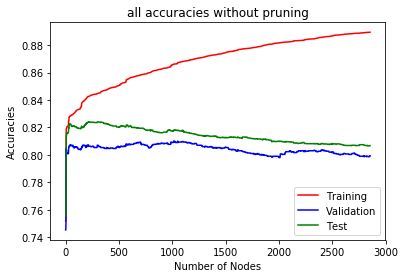

In [470]:
import matplotlib.pyplot as plt
plt.plot(train_accur,'r',label="Training")
plt.plot(valid_accur,'b',label="Validation")
plt.plot(test_accur,'g',label="Test")
plt.legend()
plt.title('all accuracies without pruning')
plt.xlabel("Number of Nodes")
plt.ylabel("Accuracies")
plt.savefig("../output/accuracy_basic.jpeg")

In [471]:
train_accur_raw = accuracy(train_data_raw,1)
valid_accur_raw = accuracy(valid_data_raw,1)
test_accur_raw = accuracy(test_data_raw,1)


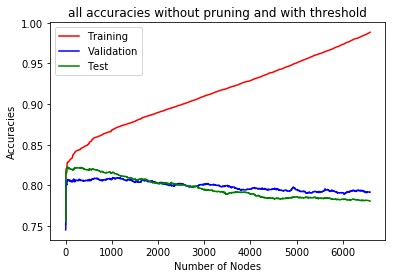

In [472]:
import matplotlib.pyplot as plt
plt.plot(train_accur_raw,'r',label="Training")
plt.plot(valid_accur_raw,'b',label="Validation")
plt.plot(test_accur_raw,'g',label="Test")
plt.legend()
plt.title('all accuracies without pruning and with threshold')
plt.xlabel("Number of Nodes")
plt.ylabel("Accuracies")
plt.savefig("../output/accuracy_basic_raw.jpeg")

In [473]:
def recur_sum(node,benef_list,sum_benef_list):
    ind = node.index_in_list
    sum_benef_list[ind] = benef_list[ind]
    for key in node.child_list.keys():
        if node.child_list[key].is_leaf==0:
            recur_sum(node.child_list[key],benef_list,sum_benef_list)
            sum_benef_list[ind] += sum_benef_list[node.child_list[key].index_in_list]

def summ(benef_list,raw):
    sum_benef_list = []
    for i in range(len(benef_list)):
        sum_benef_list.append(0)
    if raw:
        recur_sum(tree_root_raw,benef_list,sum_benef_list)
    else:
        recur_sum(tree_root,benef_list,sum_benef_list)
    return sum_benef_list
def node_count(node):
    count = 1
    for key in node.child_list.keys():
        if node.child_list[key].is_leaf==0:
            count += node_count(node.child_list[key])
    return count

In [485]:
tree_root = make_tree(base_pos,base_neg,0)

In [486]:
def prune_tree(data,raw):
    if raw:
        num_nodes = len(global_node_list_raw)
    else:
        num_nodes = len(global_node_list)
    benef_list = []
    for i in range(num_nodes):
        benef_list.append(0)
    pos_list = []
    neg_list = []
    for i in range(len(data)):
        if data[i][0] == 1:
            pos_list.append(data[i])
        else:
            neg_list.append(data[i])
    if raw:
        accuracy_recur(pos_list,neg_list,tree_root_raw,benef_list,raw)
    else:
        accuracy_recur(pos_list,neg_list,tree_root,benef_list,raw)
    miss_change = []
    node_change = []
    while True:
        sum_benef_list = summ(benef_list,raw)
        minind = -1
        minn = 0
        for i in range(len(sum_benef_list)):
            if sum_benef_list[i] < minn :
                minind = i
                minn = sum_benef_list[i]
        if minind == -1:
            break
        if raw:
            node = global_node_list_raw[minind]
        else:
            node = global_node_list[minind]
        removed = node_count(node)
        miss_change.append(-1*minn/(1.0*len(data)))
        node_change.append(-1*removed)
        node.is_leaf = 1
        node.attr = None
        node.child_list = None
    return (miss_change,node_change)

In [487]:
miss_change,node_change = prune_tree(valid_data,0)

In [489]:
print (miss_change)
print (node_change)

[0.008333333333333333, 0.0016666666666666668, 0.0013333333333333333, 0.0013333333333333333, 0.001, 0.001, 0.001, 0.001, 0.0006666666666666666, 0.0006666666666666666, 0.0006666666666666666, 0.0006666666666666666, 0.0006666666666666666, 0.0006666666666666666, 0.0006666666666666666, 0.0006666666666666666, 0.0006666666666666666, 0.0006666666666666666, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003333333333333333, 0.0003

In [447]:
train_accur_prune = accuracy(train_data,0)
valid_accur_prune = accuracy(valid_data,0)
test_accur_prune = accuracy(test_data,0)

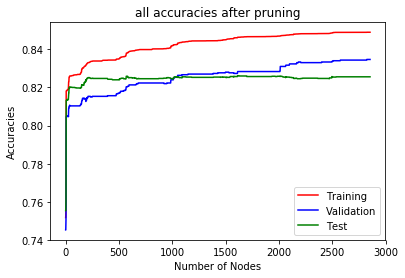

In [448]:
import matplotlib.pyplot as plt
plt.plot(train_accur_prune,'r',label="Training")
plt.plot(valid_accur_prune,'b',label="Validation")
plt.plot(test_accur_prune,'g',label="Test")
plt.legend()
plt.title('all accuracies after pruning')
plt.xlabel("Number of Nodes")
plt.ylabel("Accuracies")
plt.savefig("../output/accuracy_basic_prune.jpeg")